# Preprocessing , training dataset
## Udacity Self Driving Car Engineer Nanodegree - Project 5

In this fill we will processs the data and train the classifier:
- Identify vehicles in images
- Track vehicles across frames in a video stream

In [1]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip
%matplotlib inline
print('Import Done')

Import Done


###Step1: Define a function to draw boxes

Defines a fucntion called draw_boxes which takes the image , box boundiries, color and thickness and input and return and image with boxes drawn on it, uses open cv function cv2.rectangle to do this.


In [2]:
def draw_boxes(img, bboxes, color=(255, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

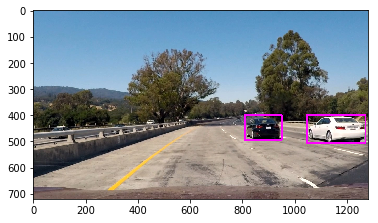

In [3]:
bboxes = [((810,400),(950,495)),((1045,400),(1270,505))]
plt.imshow(draw_boxes(mpimg.imread('test_images/test1.jpg'),bboxes=bboxes));

###Step2:Convert the provided input data to YUV and colour space and apply the HOG transform

In this step I defined two functions

features_extration_multiple_images –>for array of images
features_extration_single_image –> for single image
the above functions are used to resize the image to specific mentioned size using cv2.resize, convert the images to specified colour spaces and finally apply the HOG transforms using hog.compute.

Performance is tested with multiple color spaces (RGB, HSV, LUV, YUV) and finally found that the performance is better with the YUV colour space.

In [4]:
#Initialize the HOG descriptor
hog = cv2.HOGDescriptor((64,64), (8,8), (8,8), (8,8), 9)
image = imread('test_images/test1.jpg')
hog.compute(image).shape

(7314624, 1)

In [5]:
# Load the vehical and non vehical images from the provided data set.
cars = glob.glob('data/vehicles/*/*.png')
notcar = glob.glob('data/non-vehicles/*/*.png')

features_extration_multiple_images
Define a function " features_extration_multiple_images"
to extract the features using HOG transforms for complete data set, it takes input as multiple images, colour to which images to be converted and resize dimensions


In [6]:
def features_extration_multiple_images(imgs, color_space='RGB', size = (64,64)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)
    for img in imgs:
        img = imread(img)
        if size != (64,64):
            img = cv2.resize(img, size)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img) 

        hog_features = np.ravel(hog.compute(feature_image))
        features.append(hog_features)
    # Return list of feature vectors
    return features

Convert the vehical and non vehical to features data.

In [7]:
# Convert the given features using the features_extration_multiple_images for the below provided dataset
car_features = features_extration_multiple_images(cars, color_space='YUV')
notcar_features = features_extration_multiple_images(notcar, color_space='YUV')

####features_extration_single_image

Define a function " features_extration_single_image"
to extract the features using HOG transforms for a single image provided, it takes a single images as input, color to which images to be converted


In [8]:
def features_extration_single_image(img, color_space='YUV'):
    
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)


    return np.ravel(hog.compute(feature_image))

Step3: Prepare the normalised input data and lables

Convert the features to zero mean and unit variance,
Prepared the labels for the provied input data vehical as “1” and non 
vehicals as “0”

Before training to any classifier this data to be normalized so, features are converted to zero mean and unit variance. 

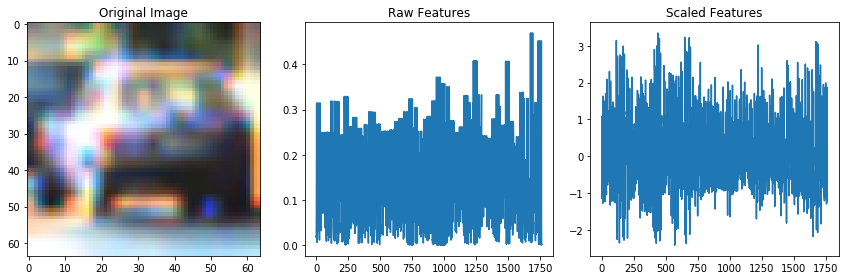

In [9]:
 # merge bot the vehical and non vehical data is to a single array 
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# fit to a pre colum scalar
X_scaler = StandardScaler().fit(X)
# scaler to X to conversion
scaled_X = X_scaler.transform(X)
#Ploting the original image, raw data and normalized data 
car_ind = np.random.randint(0, len(cars))

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Scaled Features')
fig.tight_layout()


Prepare the labels for the provied input data
vehical as "1" and non vehicals as "0"

In [10]:

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


Split the input data to train and test set 80% will be train data and 20% will be test data

In [11]:
rand_state = 444
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

Step 4: Select the best classifier and train and test the data

The next step is to select the classifier. The below three classifier are choosen to select one among them.

Linear Support Vector Machine
Logistic Regression Classifier
Multi-layer Perceptron
These were the results of training and testing on each one:

Classifier Training Accuracy Test Accuracy Prediction Time 
LinearSVC 1.00 .982 .0016sec 
Logistic Regression 1.00 .987 .0002 
Multi-layer Perceptron 1.00 .992 .0008

from the above results i have selected the MLP classifier.

In [12]:
mlp=MLPClassifier(random_state=999)
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train MLP...')
# Printing the accuracy of MLP
print('Train Accuracy = ', mlp.score(X_train, y_train))
print('Test Accuracy = ', mlp.score(X_test, y_test))


13.384933948516846 Seconds to train MLP...
Train Accuracy =  1.0
Test Accuracy =  0.992398648649


In [13]:
# Visualize a confusion matrix of the predictions from the MLP
pred = mlp.predict(X_test)
#helps to plot the difference in the prediction output and actual output
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

,0,1
0,1776,20
1,7,1749


Saving the classifier data, to load directly when needed.

In [14]:
# Save MLP and Scaler
joblib.dump(mlp, 'MLP_classifier.pkl')
joblib.dump(X_scaler, 'scaler_data.pkl')

['scaler_data.pkl']

In [15]:
# Load MLP and Scaler
mlp = joblib.load('MLP_classifier.pkl')
X_scaler = joblib.load('scaler_data.pkl')

Step 5: Define the sliding window

In sliding window approach I have choosen one slice of image at 
once and applied the HOG transforms on that particular window.
Two minimize the search time and speed up pipeline , i have 
eliminated the upper part of the image.
The sliding varies in various rages with a overlap of 80% is used, 
to not miss the far and near vehicals which varies in size.
For better results, i have used the function predict_proba which 
results probability of each class i.e car or non cars.
The thershold i have selected is 99% to avoid the false predictions 
for each window.
Once the search for vehicals in the windows of all the sizes are done , then the 
boundary boxes are drawn to black image of same size(masked image).
Next I use the OpenCV function cv2.findContours to find all of the 
objects in the masked image and once the contours are found
Next I used the OpenCV function cv2.boundingRect on each contour to 
get the coordinates of the bounding rect for each vehicle.
Finally merged the orinal image and the annotated image which finds 
the vehicals.

In [16]:
def sliding_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
def find_vehicals(image):
    image = imread(image)
    detected = []
    size = 320
    count = 0
    while size < 720:
        windows = sliding_window(image, x_start_stop=[None, None], y_start_stop=[400, 660], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = features_extration_single_image(current,color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
            count += 1
        size += 16
    result = np.copy(image)
    found_cars = np.zeros_like(image)
    # Draw all the boxes detected
    found_cars = draw_boxes(found_cars, bboxes=detected, thick=-1)
    #Contours can be explained simply as a curve joining all the continuous points (along the boundary), 
    #having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.
    im2, contours, hierarchy = cv2.findContours(found_cars[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # get the boundaries of the eac contours
        x,y,w,h = cv2.boundingRect(cnt)
        # Draw the rectangle on the empty image
        cv2.rectangle(result, (x, y), (x + w, y + h), (255, 0, 255), 6)
    
    #plot the images for car detections and find_vehical images
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    f.tight_layout()
    ax1.axis('off')
    ax1.set_title('Image')
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('Car Detections')
    ax2.imshow(found_cars, cmap='hot')
    ax3.axis('off')
    ax3.set_title('find_vehicals Image')
    ax3.imshow(result)

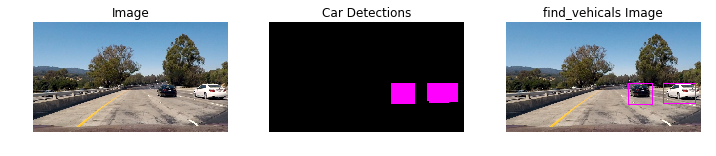

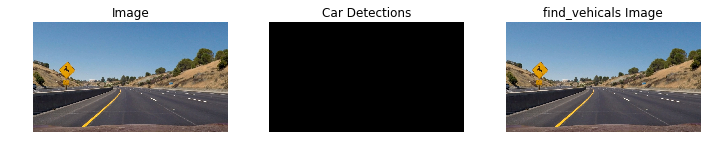

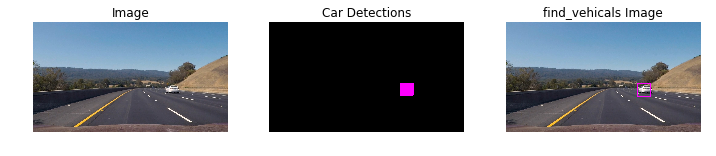

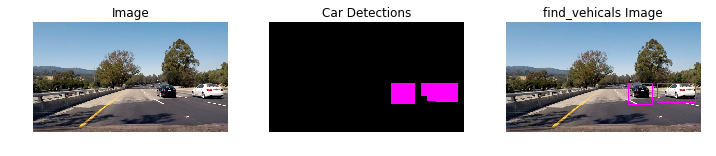

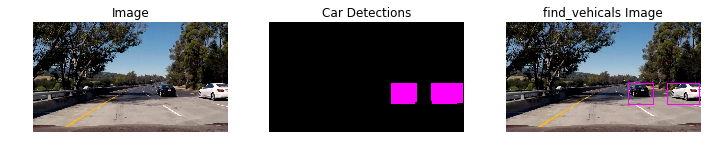

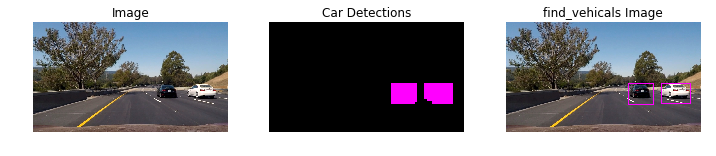

In [18]:
for image in glob.glob('test_images/*.jpg'):
    find_vehicals(image);

Step 6: Define the class for video pipelines and draw boxes for found lines

Finally to find the vehicals in the input video stream, a new class 
is created to store all the rectangle boundaries in past 12 frames in a list.

Then in each frame combine the rectangle from the present frame to 
previous frame and group it using cv2.groupRectangles function 
which combines the over lapping rectangles in to a single rectangle

Here an addtional advantge is the threshold setting which helps to 
eleminate the false finding. In detail if parameter set to 10 means 
it will look for the ten overlaps and ignore the rest. So here the 
vehical should be detected in 10 frames out of 12. Thus false 
positive will be eleminated.

In [19]:
from collections import deque
class found_boxes:
    def __init__(self):
        self.count = 0
        self.detections = deque(maxlen=12)

In [20]:
def processing_video(image):
    detected = [] 
    size = 320
    count = 0
    while size < 720:
        windows = sliding_window(image, x_start_stop=[640, None], y_start_stop=[400, 660], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = features_extration_single_image(current, color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
            count += 1
        size += 16
    result = np.copy(image).astype('uint8')
    found_cars = np.zeros_like(image)
    found_cars = draw_boxes(found_cars, bboxes=detected, thick=-1)
    rect_list = []
    im2, contours, hierarchy = cv2.findContours(found_cars[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rect_list.append([x,y,x+w,y+h])
    Found_Boxes.detections.append(rect_list)
    all_boxes = []
    combined = np.ravel(np.array(Found_Boxes.detections))
    for i in range(len(combined)):
        all_boxes.extend(np.ravel(combined[i]))
    new_boxes = []
    i = 0
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i+4])
        i += 4
    rects,w = cv2.groupRectangles(np.array(new_boxes).tolist(), 10,.1)
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (255,0,255), 5)
    Found_Boxes.count += 1
    return result

In [21]:
Found_Boxes = found_boxes()
output = 'result.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(processing_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:17<00:00,  4.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 5min 18s
